In [52]:
from scipy.io import loadmat
from pylab import *
import numpy
from glob import glob
from matplotlib.cm import get_cmap
from scipy.optimize import curve_fit
%matplotlib inline

def XtalPosition(Xmir,Ymir):
    Xcenter = 0.010
    Ycenter = 0.124

    #Define Linear Transformation Matrix:
    M = [[0.168333,0],[0.000952381,0.163095]]
    Minv = [[5.94059,0],[-0.0346896,6.13139]]
    
    Xmir -= Xcenter
    Ymir -= Ycenter
    Xmirror = Minv[0][0]*Xmir + Minv[0][1]*Ymir
    Ymirror = Minv[1][0]*Xmir + Minv[1][1]*Ymir
    
    return Xmirror,Ymirror

def Gaussian(x,sigma,amp,offset):
    return abs(amp)*exp(-x**2/(2*sigma**2))+offset

def GaussianNO(x,sigma,amp):
    return abs(amp)*exp(-x**2/(2*sigma**2))

def Gaussian2D(x,y,sigma,amp,aspect):
    return abs(amp)*exp(-x**2/(2*sigma**2)-y**2/(sqrt(2)*sigma*aspect)**2)

def FitValley(x,y,r,s,xcenters,ycenters,makePlots=True,plotStr=None):
    fitpts0=x<xcenters[0]
    fitpts1=(y-ycenters[2])>-(x-xcenters[2])*0.577
    fitpts2=(y-ycenters[1])<(x-xcenters[1])*0.577
    fitpts=numpy.logical_or(fitpts0,fitpts1)
    fitpts=numpy.logical_or(fitpts,fitpts2)
    
    xv=x[fitpts]
    yv=y[fitpts]
    rv=r[fitpts]
    sv=s[fitpts]
    
    popt, pcov = curve_fit(Gaussian, rv, sv)
    
    if(makePlots):
        fig=figure(figsize=(14,6))
        subplot(1,2,1)
        scatter(xv,yv,c=sv,marker="s",edgecolor='face')
        xlim(-3,3)
        ylim(-3,3)
        gca().set_aspect('equal')
        xlabel('X Position (mm)')
        ylabel('Y Position (mm)')
        subplot(1,2,2)
        scatter(rv,sv,s=2)
        rInput=numpy.arange(0,2.0,0.01)
        plot(rInput,Gaussian(rInput,popt[0],popt[1],popt[2]))
        xlim(0,2)
        if(plotStr == None):
            show()
        else:
            savefig(plotStr)
        close(fig)
        
    return popt

def AnalyzeImage(filename,xcenters,ycenters,CutLevel=2,edgeCuts=True,valleyAspect=0.375,ellRad=0.35,makePlot=True):
    res=loadmat(filename,squeeze_me=True,variable_names=['x','y','a1','a2','Vbias','Wpulse'])

    x,y = XtalPosition(res['x'],res['y'])
    vbias=-res['Vbias']
    wp=res['Wpulse']
    retval=dict()
    retval['v']=vbias
    retval['wp']=wp
    
    noiseRad=0.35
    noiseAspect=0.375
    xpCenter=numpy.mean(xcenters)
    ypCenter=numpy.mean(ycenters)
    patternRadius=numpy.mean(sqrt(numpy.array(xcenters)**2+numpy.array(ycenters)**2))
    for j in range(0,3):
        ctheta=2.0*pi/3.0*j+pi/3.0
        theta=2.0*pi/3.0*(j-1)
        xc=-patternRadius*cos(ctheta)+xpCenter
        yc=patternRadius*sin(ctheta)+ypCenter
        xrot=(x-xc)*cos(theta)-(y-yc)*sin(theta)
        yrot=(x-xc)*sin(theta)+(y-yc)*cos(theta)
        rad = sqrt(xrot**2+noiseAspect**2*yrot**2)
        if(j == 0):
            noisePts = rad < noiseRad
        else:
            noisePts = numpy.logical_or(noisePts,rad < noiseRad)
    noise=res['a1'][noisePts]*1e3
        
    NoiseMean = numpy.mean(noise)
    NoiseStd = numpy.std(noise)
    NoiseCut=CutLevel*NoiseStd
    Signal=res['a1']*1e3
    Signal-=NoiseMean
    pts=Signal > NoiseCut
    if(edgeCuts):
        pts=numpy.logical_and(pts,y < (0.577*x+2.45))
        pts=numpy.logical_and(pts,y > (-0.577*x-2.45))
        pts=numpy.logical_and(pts,x<2.2)
        pts=numpy.logical_and(pts,y<2.7)
        
    retval['noiseMean']=NoiseMean
    retval['noiseStd']=NoiseStd
    
    retval['CenterRadius']=numpy.sqrt((x-xpCenter)**2+(y-ypCenter)**2)[pts]
    retval['Signal']=Signal[pts]

    thetas=numpy.arange(0,2*pi,1e-3*pi)
    r = sqrt((x-xcenters[0])**2+(valleyAspect)**2*(y-ycenters[0])**2)
    for j in range(1,len(xcenters)):
        theta=pi-2.0*pi/3.0*j
        xrot=(x-xcenters[j])*cos(theta)-(y-ycenters[j])*sin(theta)
        yrot=(x-xcenters[j])*sin(theta)+(y-ycenters[j])*cos(theta)
        rnew = sqrt(xrot**2+valleyAspect**2*yrot**2)
        r[rnew < r]=rnew[rnew < r]
    
    slope=[0.0,0.0,0.0]
    slope[0]=(ycenters[1]-ycenters[0])/(xcenters[1]-xcenters[0])
    slope[1]=(ycenters[2]-ycenters[1])/(xcenters[2]-xcenters[1])
    slope[2]=(ycenters[0]-ycenters[2])/(xcenters[0]-xcenters[2])
    slope=numpy.array(slope)
    
    lineAngleCorr=cos(arctan(slope))
    
    offset=[0.0,0.0,0.0]
    dSign=[1.0,1.0,1.0]
    for j in range(0,3):
        offset[j]=ycenters[j]-slope[j]*xcenters[j] 
        if(offset[j] < 0):
            dSign[j] = -1.0

    d = dSign[0]*(y-(slope[0]*x+offset[0]))*lineAngleCorr[0]
    for j in range(1,len(xcenters)):
        dnew = dSign[j]*(y-(slope[j]*x+offset[j]))*lineAngleCorr[j]
        d[abs(dnew) < abs(d)]=dnew[abs(dnew) < abs(d)]
        
    [gsig,gamp,goff]=FitValley(x[pts],y[pts],r[pts],Signal[pts],xcenters,ycenters,plotStr='ElectronSideValley_W'+str(wp)+'_V'+str(vbias))
    retval['ValleyWidth']=gsig
    retval['ValleyHeight']=gamp
    
    #xun=numpy.unique(x)
    #yun=numpy.unique(y)
    #if(abs(gsig) < 1.0):
    #    retval['ValleyIntegral']=2*pi*abs(gamp)*gsig**2/valleyAspect/abs((xun[1]-xun[0])*(yun[1]-yun[0]))
    #else:
    #    retval['ValleyIntegral']=0        
    
    vpts=numpy.logical_and(pts,r<ellRad)
    vptsInt=numpy.logical_and(pts,r<1.0)
    ivpts=numpy.logical_and(pts,r>=ellRad)
    s1pts=numpy.logical_and(ivpts,d>=0)
    snpts=numpy.logical_and(ivpts,d<0)
    tot=numpy.sum(Signal[pts])
    
    retval['CenterRadiusIV']=numpy.sqrt((x-xpCenter)**2+(y-ypCenter)**2)[ivpts]
    retval['SignalIV']=Signal[ivpts]
    
    retval['ValleyPop']=numpy.sum(Signal[vpts])/tot
    noiseFloor=3*NoiseStd/sqrt(float(len(vpts)))/tot
    if(retval['ValleyPop'] < noiseFloor):
        retval['ValleyPop']=noiseFloor
        
    if(abs(gsig) < 1.0):
        samplePts=Gaussian(r[vptsInt],gsig,gamp,goff)
        retval['ValleyIntegral']=numpy.sum(samplePts)/tot
    else:
        samplePts=numpy.zeros(len(r[vptsInt]))
        retval['ValleyIntegral']=noiseFloor
        
    vdiff=retval['ValleyPop']-retval['ValleyIntegral']
    if(vdiff < 0 ):
        vdiff=0.0
        
    diagRatio=0.4
    retval['DiagPop']=numpy.sum(Signal[s1pts])/tot*(1+diagRatio)
    retval['DiagPopInt']=retval['DiagPop']+vdiff
    noiseFloor=3*NoiseStd/sqrt(float(len(s1pts)))/tot
    if(retval['DiagPop'] < noiseFloor):
        retval['DiagPop']=noiseFloor
        
    retval['TriPop']=(numpy.sum(Signal[snpts])-numpy.sum(Signal[s1pts])*diagRatio)/tot
    noiseFloor=3*NoiseStd/sqrt(float(len(snpts)))/tot
    if(retval['TriPop'] < noiseFloor):
        retval['TriPop']=noiseFloor
        
    retval['IVPop']=numpy.sum(Signal[ivpts])/tot
    noiseFloor=3*NoiseStd/sqrt(float(len(ivpts)))/tot
    if(retval['IVPop'] < noiseFloor):
        retval['IVPop']=noiseFloor
    
    if(makePlot):
        fig=figure(figsize=(13,12))
        clf()
        subplot(2,2,1)
    
        scatter(x[pts],y[pts],c=Signal[pts],marker="s",edgecolor='face')
        scatter(x[noisePts],y[noisePts],c=Signal[noisePts],marker="s",edgecolor='face')
        xlim(-3,3)
        ylim(-3,3)
        gca().set_aspect('equal')
        title('V='+str(vbias)+', W='+str(wp)+', Charge')
        xlabel('X Position (mm)')
        ylabel('Y Position (mm)')
    
        xellipse=ellRad*cos(thetas)+xcenters[0]
        yellipse=ellRad*sin(thetas)/valleyAspect+ycenters[0]
        plot(xellipse,yellipse,color='red')
        for j in range(1,len(xcenters)):
            theta=2.0*pi/3.0*j
            xellipse=ellRad*cos(thetas)*cos(theta)-ellRad/valleyAspect*sin(theta)*sin(thetas)+xcenters[j]
            yellipse=ellRad*cos(thetas)*sin(theta)+ellRad*sin(thetas)*cos(theta)/valleyAspect+ycenters[j]
            plot(xellipse,yellipse,color='red')
            
        plot([xcenters[0],xcenters[1]],[ycenters[0],ycenters[1]],color='red')
        plot([xcenters[0],xcenters[2]],[ycenters[0],ycenters[2]],color='red')
        plot([xcenters[2],xcenters[1]],[ycenters[2],ycenters[1]],color='red')
    
        subplot(2,2,2)
    
        vpts=numpy.logical_and(pts,r<ellRad)
        scatter(x[vpts],y[vpts],c='blue',marker="s",edgecolor='face')
        ivpts=numpy.logical_and(pts,r>=ellRad)
        #scatter(x[ivpts],y[ivpts],c='red',marker="s",edgecolor='face')
        scatter(x[s1pts],y[s1pts],c='red',marker="s",edgecolor='face')
        scatter(x[snpts],y[snpts],c='purple',marker="s",edgecolor='face')
        scatter(x[noisePts],y[noisePts],c='green',marker="s",edgecolor='face')
        xlim(-3,3)
        ylim(-3,3)
        gca().set_aspect('equal')
        title('V='+str(vbias)+', W='+str(wp)+', Scatter State')
        xlabel('X Position (mm)')
        ylabel('Y Position (mm)')
    
        xellipse=ellRad*cos(thetas)+xcenters[0]
        yellipse=ellRad*sin(thetas)/valleyAspect+ycenters[0]
        plot(xellipse,yellipse,color='red')
        for j in range(1,len(xcenters)):
            theta=2.0*pi/3.0*j
            xellipse=ellRad*cos(thetas)*cos(theta)-ellRad/valleyAspect*sin(theta)*sin(thetas)+xcenters[j]
            yellipse=ellRad*cos(thetas)*sin(theta)+ellRad*sin(thetas)*cos(theta)/valleyAspect+ycenters[j]
            plot(xellipse,yellipse,color='red')
    
        rmax=numpy.max(r[ivpts])
        subplot(2,2,3)
        #scatter(r,Signal,s=1)
        scatter(r[ivpts],Signal[ivpts],color='red',s=2,edgecolor='face')
        scatter(r[vpts],Signal[vpts],color='blue',s=2,edgecolor='face')
        scatter(r[noisePts],Signal[noisePts],color='green',s=2,edgecolor='face')
        if(CutLevel > -6):
            plot([0,2],[NoiseCut,NoiseCut])
        rInput=numpy.arange(0,2.0,0.01)
        glabel='$\sigma$={0:.2f}, Amp={1:.2f}, Off={2:.2f}'.format(gsig,gamp,goff)
        plot(rInput,Gaussian(rInput,gsig,gamp,goff),label=glabel)
        scatter(r[vptsInt],samplePts,color='cyan',s=2,edgecolor='face')
        legend(loc='upper right')
        xlabel('Radius (mm)')
        ylabel('Charge Density (mV/pixel)')
        xlim(0,rmax)
    
        subplot(2,2,4)
        hist(r[pts],weights=Signal[pts],bins=30)
        xlabel('Radius (mm)')
        ylabel('Charge Collected (mV)')
        xlim(0,rmax)
    
        if(CutLevel > -6):
            savefig('ElectronSide_'+str(CutLevel)+'Sigma_W'+str(wp)+'_V'+str(vbias))
        else:
            savefig('ElectronSide_W'+str(wp)+'_V'+str(vbias))
        close(fig)
    return retval

0.0751502
-2.970295 2.970295 0.0752078694 78.9889415482
-3.10756536 3.05851424 0.000439170336 14040.2916467


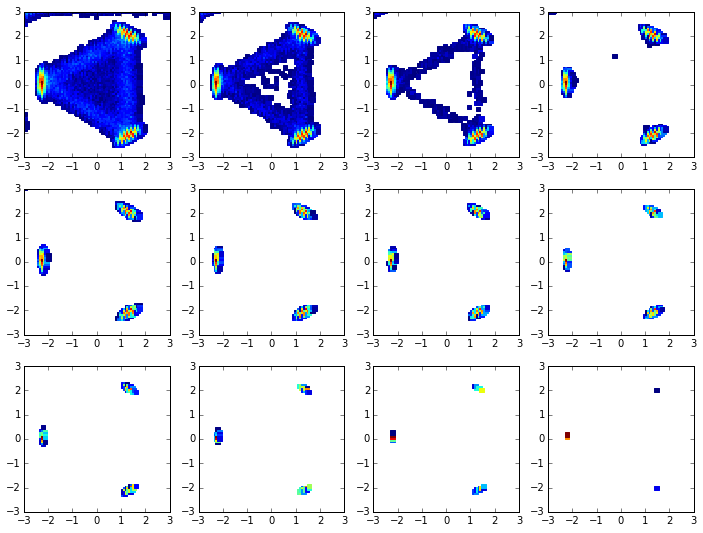

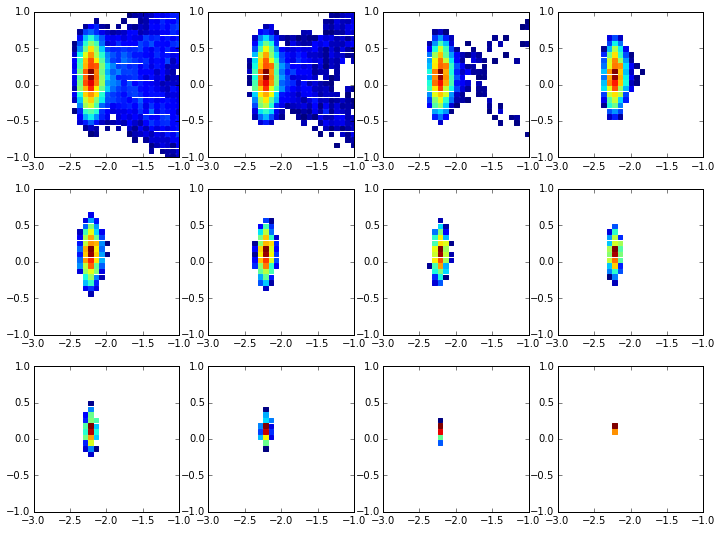

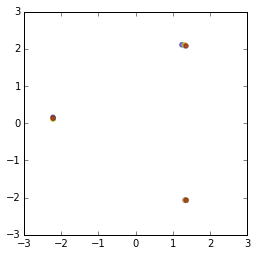

-2.21778267868 0.12597457262
1.3445046189 -2.06920204572
1.31561850804 2.09363632033


In [50]:
fname='/neroscratch/rmoffatt/Run10/ProcessedData/Scan-2016-05-02-0940.mat'
res=loadmat(fname,squeeze_me=True,variable_names=['x','y','a1','a2'])
x,y = XtalPosition(res['x'],res['y'])
i=0
cuts=numpy.arange(0.015,0.070,0.005)
figure(figsize=(12,9))
xmeans=list()
ymeans=list()
print max(res['a1'])
xvals=numpy.unique(x)
yvals=numpy.unique(y)
print min(xvals),max(xvals),xvals[1]-xvals[0], (max(xvals) - min(xvals))/(xvals[1]-xvals[0])
print min(yvals),max(yvals),yvals[1]-yvals[0], (max(yvals) - min(yvals))/(yvals[1]-yvals[0])
for cut in cuts:
    i=i+1
    subplot(3,4,i)
    pts=res['a1']>cut
    scatter(x[pts],y[pts],c=res['a1'][pts],marker="s",edgecolor='face')
    xlim(-3,3)
    ylim(-3,3)
    gca().set_aspect('equal')
    
    xtest=x[pts]
    ytest=y[pts]
    
    xmean=[0,0,0]
    ymean=[0,0,0]

    xmean[0]=numpy.mean(xtest[xtest < 0])
    ymean[0]=numpy.mean(ytest[xtest < 0])
    
    xmean[1]=numpy.mean(xtest[ytest > 1.2])
    ymean[1]=numpy.mean(ytest[ytest > 1.2])
    
    xmean[2]=numpy.mean(xtest[ytest < -1.2])
    ymean[2]=numpy.mean(ytest[ytest < -1.2])
    
    xmeans.append(xmean)
    ymeans.append(ymean)
show()

i=0
figure(figsize=(12,9))
for cut in cuts:
    i=i+1
    subplot(3,4,i)
    pts=res['a1']>cut
    scatter(x[pts],y[pts],c=res['a1'][pts],marker="s",edgecolor='face')
    xlim(-3,3)
    ylim(-3,3)
    gca().set_aspect('equal')

    xlim(-3,-1)
    ylim(-1,1)
show()

i=0
xs=list()
ys=list()
cs=list()
for i in range(4,len(xmeans)-2):
    xm=xmeans[i]
    ym=ymeans[i]
    cm=numpy.zeros(len(xm))+float(i)/float(len(xmeans)-1)
    for j in range(0,len(xm)):
        xs.append(xm[j])
        ys.append(ym[j])
        cs.append(cm[j])
    
scatter(xs,ys,c=cs,edgecolor='face',alpha=0.5)
xlim(-3,3)
ylim(-3,3)
gca().set_aspect('equal')
show()

xs=numpy.array(xs)
ys=numpy.array(ys)
cs=numpy.array(cs)

xcenters=[numpy.mean(xs[xs < 0]),numpy.mean(xs[ys < -1.2]),numpy.mean(xs[ys > 1.2])]
ycenters=[numpy.mean(ys[xs < 0]),numpy.mean(ys[ys < -1.2]),numpy.mean(ys[ys > 1.2])]

for i in range(0,len(xcenters)):
    print xcenters[i],ycenters[i]

[0.20007645, 0.27432641, 0.31329116, 0.32243979, 0.31783003, 0.29187509, 0.24889927, 0.19917727, 0.14385496, 0.094925806, 0.055489704, 0.027313313, 0.0035364644, 0.0021399958, 0.00022382954, 0.0043863244]
[ 2.74695277  3.41725326  3.80830216  3.9051497   3.85609078  3.58932495
  3.17823958  2.73928452  2.27958465  1.8771292   1.52858794  1.22764778
  0.78304547  0.71905565  0.5259009   0.81410676]


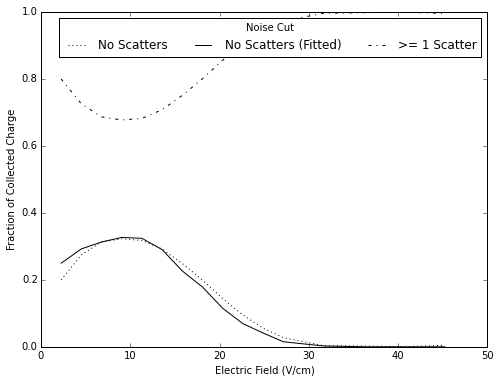

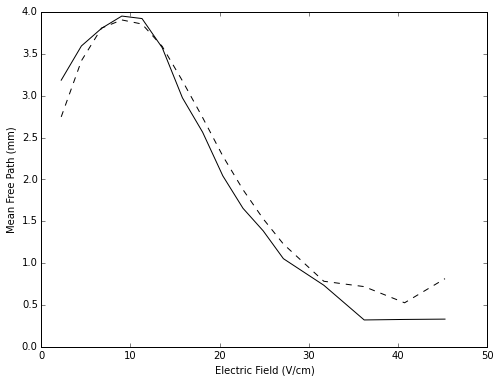

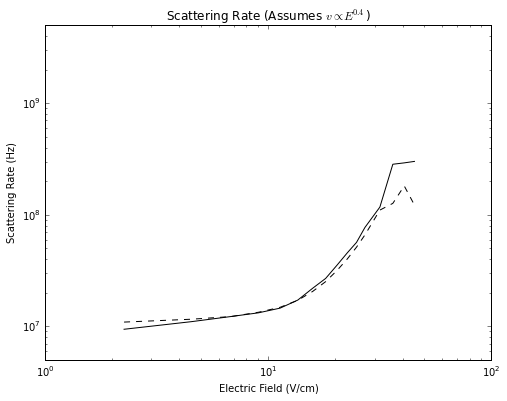

In [78]:
files=glob('/neroscratch/rmoffatt/Run10/ProcessedData/Scan-2016-05-0*.mat')
files.append('/neroscratch/rmoffatt/Run10/ProcessedData/Scan-2016-08-27-1526.mat')
files.append('/neroscratch/rmoffatt/Run10/ProcessedData/Scan-2016-08-27-1833.mat')
files.append('/neroscratch/rmoffatt/Run10/ProcessedData/Scan-2016-08-27-2339.mat')
files.append('/neroscratch/rmoffatt/Run10/ProcessedData/Scan-2016-08-28-0245.mat')
vbias=list()
wp=list()
for f in files:
    res=loadmat(f,squeeze_me=True,variable_names=['Vbias','Wpulse'])
    vbias.append(-1*res['Vbias'])
    wp.append(res['Wpulse'])

count=0
order=numpy.argsort(vbias)
targetfiles=list()
for i in order:
    if(vbias[i]<0 or wp[i] == 5e-8):
        continue
    targetfiles.append(files[i])
    count+=1

thickness=4.42e-3

nmean=list()
nsigma=list()
nv=list()
vpct=list()
vint=list()
ivpct=list()
s1pct=list()
s1int=list()
snpct=list()

sigs=list()
rs=list()

for f in targetfiles:
    res=AnalyzeImage(f,xcenters,ycenters,CutLevel=-6)
    nv.append(res['v'])
    nsigma.append(res['noiseStd'])
    nmean.append(res['noiseMean'])
    vint.append(res['ValleyIntegral'])
    vpct.append(res['ValleyPop'])
    ivpct.append(res['IVPop'])
    s1int.append(res['DiagPopInt'])
    s1pct.append(res['DiagPop'])
    snpct.append(res['TriPop'])
    sigs.append(res['SignalIV'])
    rs.append(res['CenterRadiusIV'])
s1pct=numpy.array(s1pct)
snpct=numpy.array(snpct)
lam=-thickness*1e3/log(vpct)
lamp=-thickness*1e3/log(vint)
lam2=(vpct/numpy.array(s1pct))*thickness*1e3
lam2p=(vint/numpy.array(s1int))*thickness*1e3
lam3=sqrt((s1pct/snpct)/2)*thickness*1e3
nv=numpy.array(nv)

Efield=numpy.array(nv)/(thickness*1e2)

cm=get_cmap('jet')
figure(figsize=(8,6))
plot(Efield,vpct,':',color='black',label='No Scatters')
plot(Efield,vint,'-',color='black',label='No Scatters (Fitted)')
plot(Efield,ivpct,'-.',color='black',label='>= 1 Scatter')
#plot(Efield,s1pct,'-.',color='black',label='1 Scatter')
#plot(Efield,snpct,':',color='black',label='At Least 2 Scatters')
legend(loc='upper right',title='Noise Cut',ncol=3)
xlabel('Electric Field (V/cm)')
ylabel('Fraction of Collected Charge')
savefig('ChargeCollection_noCut')

print vpct
print lam
figure(figsize=(8,6))
plot(Efield,lam,'--',color='black',label='Peaks Only')
plot(Efield,lamp,color='black',label='Peaks Only (Fitted)')
#plot(Efield,lam2,'--',color='blue',label='1 Scatter/ No Scatters')
#plot(Efield,lam2p,color='blue',label='1 Scatter/ No Scatters (Fitted)')
#plot(Efield,lam3,'--',color='green',label='$>$1 Scatter/ 1 Scatter')
ylabel('Mean Free Path (mm)')
xlabel('Electric Field (V/cm)')
savefig('MeanFreePath_noCut')

figure(figsize=(8,6))
v=3e6*10
plot(Efield,v/lam*nv**(0.4),'--',color='black')
plot(Efield,v/lamp*nv**(0.4),'-',color='black')
#plot(Efield,v/lam2*nv**(0.4),'--',color='black')
#plot(Efield,v/lam3*nv**(0.4),':',color='black')
yscale('log')
xscale('log')
ylabel('Scattering Rate (Hz)')
xlabel('Electric Field (V/cm)')
ylim(5e6,5e9)
title('Scattering Rate (Assumes $v\propto E^{0.4}$)')
savefig('ScatteringRate_noCut')

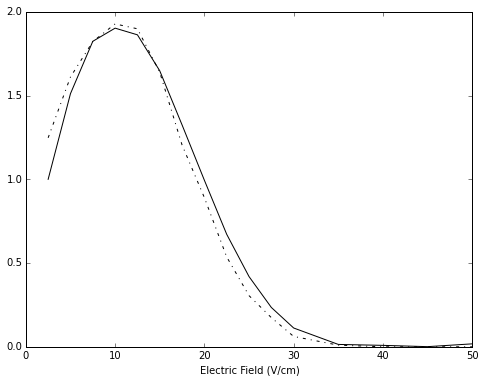

In [58]:
figure(figsize=(8,6))
plot(Efield,(vpct/numpy.array(ivpct))*thickness*1e3,'-',color='black',label='1 Scatter/ No Scatters')
plot(Efield,(newVpct/numpy.array(ivpct))*thickness*1e3,'-.',color='black',label='1 Scatter (Int)/ No Scatters')
#legend(loc='upper right',title='Noise Cut',ncol=3)
xlabel('Electric Field (V/cm)')
#ylabel('Fraction of Collected Charge')
savefig('ChargeCollection_noCut')

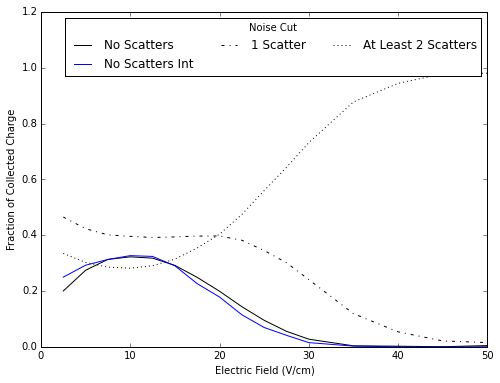

In [54]:
newVpct=numpy.array(vint)

cm=get_cmap('jet')
figure(figsize=(8,6))
plot(Efield,vpct,color='black',label='No Scatters')
plot(Efield,numpy.array(vint),color='blue',label='No Scatters Int')
#plot(Efield,ivpct,'--',color='black',label='At Least 1 Scatter')
plot(Efield,s1pct,'-.',color='black',label='1 Scatter')
plot(Efield,snpct,':',color='black',label='At Least 2 Scatters')
legend(loc='upper right',title='Noise Cut',ncol=3)
xlabel('Electric Field (V/cm)')
ylabel('Fraction of Collected Charge')
ylim(0,1.2)
show()

20 0.424485657619
18 0.50148324412
16 0.576042317366
14 0.710827831629
12 0.913946943329
11 1.03652331236
10 1.16274537948
9 1.29473997185
8 1.42037157879
7 1.50186140035
6 1.60297914337
5 1.6785632681
4 1.71785216665
3 1.72593901252
2 1.74106922503
1 1.69843105247


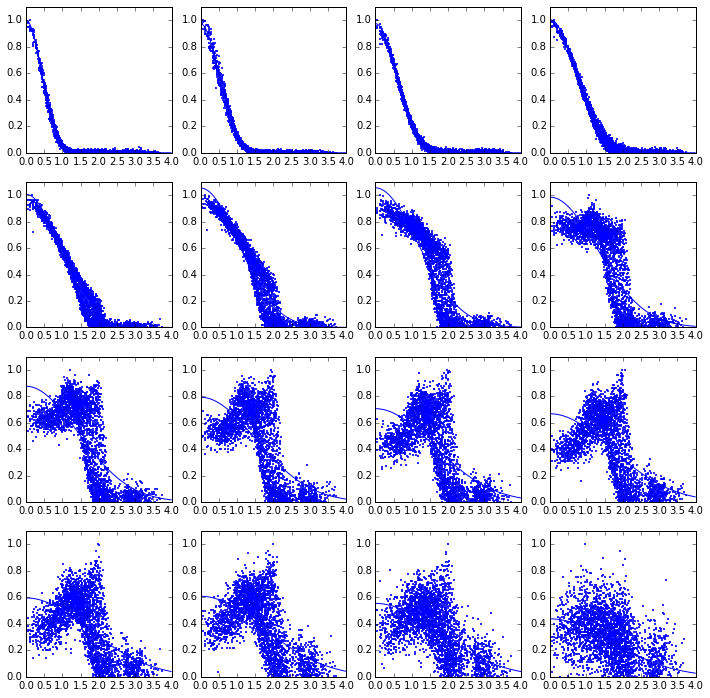

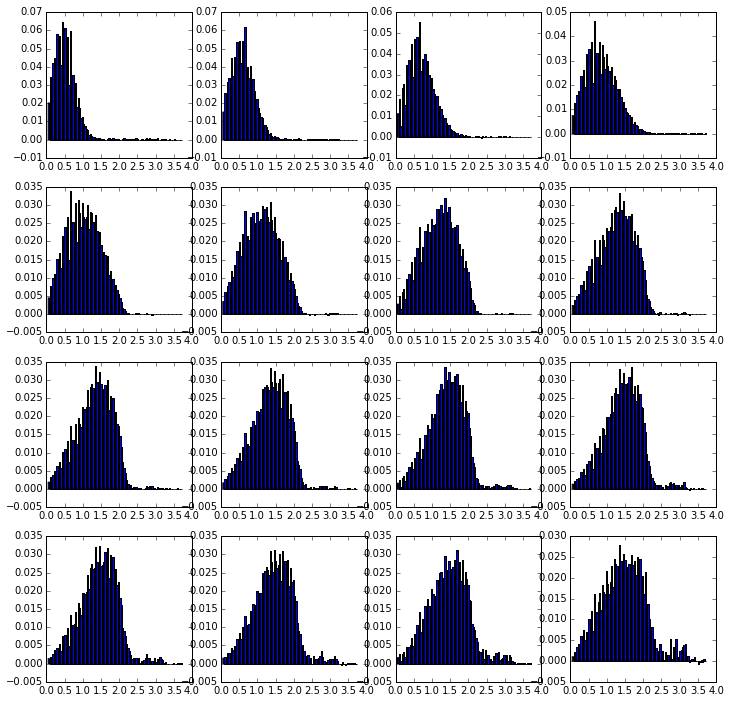

In [55]:
def weighted_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = numpy.average(values, weights=weights)
    variance = numpy.average((values-average)**2, weights=weights)  # Fast and numerically precise
    return math.sqrt(variance)

figure(figsize=(12,12))
lamStd=numpy.zeros(len(nv))
for i in range(1,17):
    subplot(4,4,i)
    vals=rs[-i]
    weights=numpy.array(sigs[-i])
    weights/=numpy.max(weights)
    scatter(vals,weights,s=1,edgecolor='face')
    #print nv[-i],weighted_std(vals,weights)/tan(pi/180*35.3)
    ylim(0,1.1)
    rInput=numpy.arange(0,4.0,0.01)
    #fitpts=logical_or(vals<0.5,vals>2.5)
    fitpts=vals<5
    popt, pcov = curve_fit(GaussianNO, vals[fitpts], weights[fitpts])
    #lamStd[-i]=weighted_std(vals,weights)#/tan(pi/180*35.3)*4
    lamStd[-i]=popt[0]
    print nv[-i],lamStd[-i]
    zInput=rInput#/tan(pi/180*35.3)*4
    plot(rInput,popt[1]*exp(-zInput**2/(2*lamStd[-i]**2)))
    xlim(0,4)
show()

figure(figsize=(12,12))
for i in range(1,17):
    subplot(4,4,i)
    vals=rs[-i]
    weights=numpy.array(sigs[-i])/numpy.sum(sigs[-i])
    hist(vals,weights=weights,bins=100)
    #ylim(0,1.1)
show()

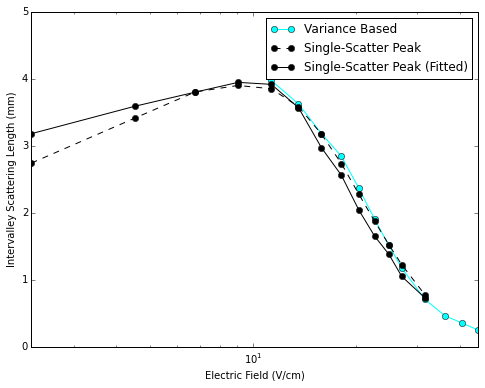

In [103]:
lamStdCorr=(lamStd)**2/tan(pi/180*35.3)

figure(figsize=(8,6))
plot(Efield[Efield >= 10],(lamStdCorr)[Efield >= 10],'-co',color='cyan',label='Variance Based')
plot(Efield[Efield < 35],(numpy.array(lam))[Efield < 35],'--bo',color='black',label='Single-Scatter Peak')
plot(Efield[Efield < 35],(numpy.array(lamp))[Efield < 35],'-bo',color='black',label='Single-Scatter Peak (Fitted)')
#plot(Efield,lam2,'--',color='blue',label='1 Scatter/ No Scatters')
#plot(Efield,lam2p,color='blue',label='1 Scatter/ No Scatters (Fitted)')
#plot(Efield,lam3,'--',color='green',label='$>$1 Scatter/ 1 Scatter')
#ylim(0,4)
#yscale('log')
#yscale('log')
xscale('log')
xlim(1/(thickness*1e2),20.0/(thickness*1e2))
ylim(0,5)
xlim(2.5,50)
legend()
xlim(1/(thickness*1e2),20.0/(thickness*1e2))
xlabel('Electric Field (V/cm)')
ylabel('Intervalley Scattering Length (mm)')
savefig('PeakvVariance_mfp')

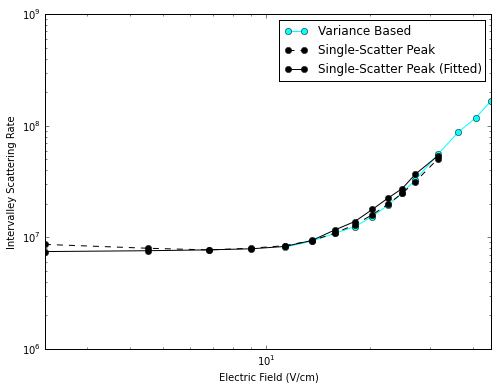

In [96]:
lamStdCorr=numpy.array((lamStd)**2/tan(pi/180*35.3))

lamMean=(lam+lamp+lam2+lam3+lam2p+lam3)/6.0

velocity=numpy.array([ 23753060.33194572,  27281183.59210701,  29394772.15722419,
        31212122.14388036,  32488283.77355495,  33527195.8414802 ,
        34688522.60067622,  35537859.77969706,  36357264.82638308,
        37204666.81218511,  37926437.87193133,  38631918.67862876,
        39784050.31781098,
        41000000.4250723 ,  41737793.88145918, 42689122.90937686])

figure(figsize=(8,6))
plot(Efield[Efield >= 10],(velocity/lamStdCorr)[Efield >= 10],'-co',color='cyan',label='Variance Based')
plot(Efield[Efield < 35],(velocity/numpy.array(lam))[Efield < 35],'--bo',color='black',label='Single-Scatter Peak')
plot(Efield[Efield < 35],(velocity/numpy.array(lamp))[Efield < 35],'-bo',color='black',label='Single-Scatter Peak (Fitted)')
#plot(Efield[Efield < 35],(velocity/numpy.array(lamMean))[Efield < 35],'--bo',color='black',label='Peaks Only (Mean)')
#ylim(0,4)
legend()
yscale('log')
xscale('log')
xlim(1/(thickness*1e2),20.0/(thickness*1e2))
ylabel('Intervalley Scattering Rate')
xlabel('Electric Field (V/cm)')
savefig('PeakvVariance_rate')

In [43]:
xmean=numpy.mean(xcenters)
ymean=numpy.mean(ycenters)

xcCorr = numpy.array(xcenters) - xmean
ycCorr = numpy.array(ycenters) - ymean
rCorr = numpy.sqrt(xcCorr**2+ycCorr**2)

print rCorr.mean()

2.38477122738


In [44]:
1/tan(pi/180*35.3)

1.4123506477064605

3.98909718535e-05
0.00222755029569
0.0333732699603
0.0913417620264
0.107319423846
0.101323398473
0.0711770322763
0.00966571504638
9.99660057793e-05


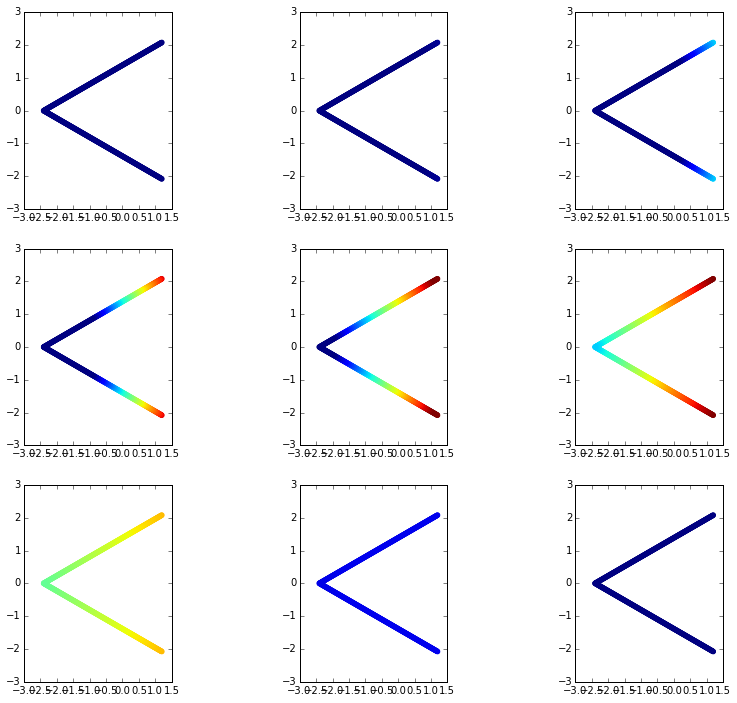

In [5]:
rmax=2.4
zmax=3.4
xs=numpy.arange(0,rmax,0.01)
zs=numpy.arange(0,zmax,0.01)
xs=zs*tan(pi/180*35.3)
figure(figsize=(14,12))
i=1
cm=get_cmap('jet')
for ls in [0.3,0.5,1.0,2.0,3.0,5.0,10.0,100.0,1e4]:
    subplot(3,3,i)
    color=exp(-zmax/ls)/ls*(1-zs/ls)
    print(max(color))
    color*=10
    #print color
    scatter((rmax-xs)*sin(pi/6)-xs,(rmax-xs)*cos(pi/6),c=cm(color),edgecolor='face')
    scatter((rmax-xs)*sin(pi/6)-xs,-(rmax-xs)*cos(pi/6),c=cm(color),edgecolor='face')
    gca().set_aspect('equal')
    i+=1